# COGS 181 Neural Networks & Deep Learning Final Project

## Setup

### Import the necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import math
import random

from PIL import Image

from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.io import read_image, ImageReadMode

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Device: cuda:0


### Configuration

In [45]:
# General Configuration

batch_size = 4
num_epochs = 5
image_size = 32

# CNN Configuration

labels_path = 'data/labels/clothing.csv'
img_dir = 'data/data_cnn'
all_images_dir = 'classification/images'
training_ratio = 0.85
momentum = 0.9
lr_cnn = 0.001

# GAN Configuration

dataroot = 'data/data_gan'
workers = 0
nc = 3
nz = 100
ngf = 64
ndf = 64
beta1 = 0.5
ngpu = 1
lr_gan = 0.0002

# Random seed
manualSeed = 360
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed);

Random Seed:  360


### Image Transformations

In [36]:
transform_seq = transforms.Compose([
    transforms.Resize(image_size, antialias=True),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## Convolution Neural Network

### Loading CNN Data

#### Copy all classified images into `img_dir`

Because I have given these images labels by hand, there are a few that have not been classified.

After hand-classifying about 5000 of the images, I decided it would be better to finish the code implementation first before focusing on classification.

In [7]:
# remove all existing image copies from img_dir
if os.path.exists(img_dir):
    os.system(f'Remove-Item {img_dir}/*')
else:
    os.mkdir(img_dir)

# copy all classified images into img_dir
labels = pd.read_csv(labels_path, header=None)

count = 0

for img_filename in labels[0]:
    count += 1
    source = os.path.join(all_images_dir, img_filename)
    destination = os.path.join(img_dir, img_filename)
    
    # instead of copying
    img = Image.open(source).convert('RGB')
    img.save(destination, 'jpeg')

In order to make the CNN incorporate the categorical features of the images, we will need to essentially encode them into the image.

This will be done by padding the top of the image with a layer of that image's `clothing_characteristics`.

#### Creating custom dataset class

In [8]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, header=None)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx,0])
        image = read_image(img_path, mode=ImageReadMode.RGB)
        image_name = img_path.split('.')[0]
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

#### Loading images into custom PyTorch dataset

In [9]:
# Load the data into a custom dataset
dataset_cnn = CustomImageDataset(labels_path, img_dir, transform_seq)

# Split up the data into testing and training data
dataset_size_cnn = dataset_cnn.__len__()
training_size_cnn = math.floor(dataset_size_cnn * training_ratio)
training_size_cnn = training_size_cnn - (training_size_cnn % batch_size)
test_size_cnn = dataset_size_cnn - training_size_cnn

training_data_cnn, test_data_cnn = torch.utils.data.random_split(dataset_cnn, [training_size_cnn, test_size_cnn])

# Create dataloaders
train_dataloader_cnn = DataLoader(training_data_cnn, batch_size=batch_size, shuffle=True, num_workers=workers)
test_dataloader_cnn = DataLoader(test_data_cnn, batch_size=batch_size, shuffle=True, num_workers=workers)

all_dataloader_cnn = DataLoader(dataset_cnn, batch_size=batch_size, shuffle=True, num_workers=workers)

classes = ('not_fasionable', 'fashionable')

In [10]:
dataiter = iter(train_dataloader_cnn)

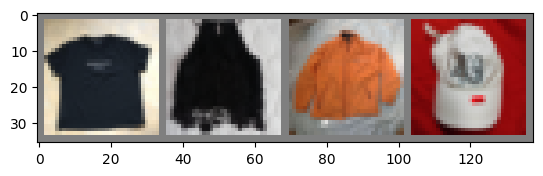

not_fasionable not_fasionable fashionable not_fasionable


In [11]:
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### CNN Setup

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 24)
        self.fc4 = nn.Linear(24, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        
        # add features of data ??
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x

In [15]:
net = CNN()
net = net.to(device)

criterion_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.SGD(net.parameters(), lr=lr_cnn, momentum=momentum)

In [16]:
for epoch in range(num_epochs):
    
    running_loss = 0.0
    for i, data in enumerate(train_dataloader_cnn, 0):
        
        inputs, labels = data
        
        inputs = inputs.to(device)
        
        labels = labels.to(device)
        
        optimizer_cnn.zero_grad()
        
        outputs = net(inputs)
        
        loss = criterion_cnn(outputs, labels)
        
        loss.backward()
        
        optimizer_cnn.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
            
print('Finished training!')

[1,   100] loss: 0.030
[1,   200] loss: 0.023
[1,   300] loss: 0.017
[1,   400] loss: 0.017
[1,   500] loss: 0.014
[1,   600] loss: 0.014
[1,   700] loss: 0.016
[1,   800] loss: 0.016
[1,   900] loss: 0.012
[2,   100] loss: 0.015
[2,   200] loss: 0.013
[2,   300] loss: 0.012
[2,   400] loss: 0.016
[2,   500] loss: 0.011
[2,   600] loss: 0.016
[2,   700] loss: 0.011
[2,   800] loss: 0.015
[2,   900] loss: 0.016
[3,   100] loss: 0.010
[3,   200] loss: 0.016
[3,   300] loss: 0.018
[3,   400] loss: 0.016
[3,   500] loss: 0.014
[3,   600] loss: 0.012
[3,   700] loss: 0.016
[3,   800] loss: 0.014
[3,   900] loss: 0.011
[4,   100] loss: 0.016
[4,   200] loss: 0.011
[4,   300] loss: 0.013
[4,   400] loss: 0.013
[4,   500] loss: 0.012
[4,   600] loss: 0.014
[4,   700] loss: 0.016
[4,   800] loss: 0.013
[4,   900] loss: 0.015
[5,   100] loss: 0.014
[5,   200] loss: 0.012
[5,   300] loss: 0.015
[5,   400] loss: 0.015
[5,   500] loss: 0.015
[5,   600] loss: 0.013
[5,   700] loss: 0.014
[5,   800] 

In [17]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader_cnn:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 92 %


## References

[[1] Optimal ratio for data splitting](https://onlinelibrary.wiley.com/doi/full/10.1002/sam.11583)

[[2] DCGAN Tutorial - PyTorch](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)

[[3] Implementing Generative Adversarial Networks (GANs) for Increasing a Convolutional Neural Network’s (CNN) Performance](https://12ft.io/proxy?q=https%3A%2F%2Ftowardsdatascience.com%2Fimplementing-generative-adversarial-networks-gans-for-increasing-a-convolutional-neural-networks-f871e17fe271)

[[3] Convolutional Neural Networks](https://12ft.io/proxy?q=https%3A%2F%2Fmedium.com%2Fswlh%2Ftraining-deep-neural-networks-on-a-gpu-with-pytorch-11079d89805)

## Data

[Fashionpedia](https://fashionpedia.github.io/home/Fashionpedia_download.html)

[Clothing Dataset - Kaggle](https://www.kaggle.com/datasets/agrigorev/clothing-dataset-full)